<a href="https://colab.research.google.com/github/suzanemenon/sentiment-analysis/blob/master/Web_Scraping_Modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
pip install GetOldTweets3

In [ ]:
#pip install NLPyPort
#https://github.com/jdportugal/NLPyPort
#text = new_full_pipe(myText, options={"lemmatizer" : True})

In [ ]:
pip install nltk==3.4.5

Name: nltk
Version: 3.4.5
Summary: Natural Language Toolkit
Home-page: http://nltk.org/
Author: Steven Bird
Author-email: stevenbird1@gmail.com
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six
Required-by: textblob, NLPyPort


In [ ]:
from bs4 import BeautifulSoup
from collections import defaultdict
from heapq import nlargest
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from skimage import io
from string import punctuation
import re
import urllib
import json
import hashlib
import csv
import pandas as pd
import time
from datetime import datetime
import numpy as np
from google.colab import files
from google.colab import drive
import io
from pytz import timezone

#Data Analysis
import seaborn as sns

#Data Preprocessing and Feature Engineering

from nltk.corpus import floresta
from nltk.stem.wordnet import WordNetLemmatizer
#RSLPStemmer - https://www.nltk.org/_modules/nltk/stem/rslp.html
from nltk.stem.rslp import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#from NLPyPort.FullPipeline import *

import nltk
nltk.download('punkt')
nltk.download('floresta')
nltk.download('stopwords')
nltk.download('rslp')

drive.mount('/drive')

#from textblob import TextBlob
#b = TextBlob(myText)
#print(b.correct())
#b.detect_language()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Package floresta is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# Common config

In [ ]:
query = 'covid-19'

period = ['2020-02-23', '2020-08-02'] #'yyyy-mm-dd'
#period = ['2020-02-23', '2020-02-23'] #'yyyy-mm-dd'

number_of_days = len(pd.date_range(start = period[0], end = period[1]))

gdrive_path = '/drive/My Drive/Colab Notebooks/TCC/'

br_timezone = timezone('America/Sao_Paulo')

def log_time():
  return datetime.now().astimezone(br_timezone).strftime('%Y/%m/%d %H:%M')

#Helpers

In [ ]:
def percentage(value, total):
  pct = float(value/total) * 100
  return str(round(pct, 2))+'%'

## Hash MD5

In [ ]:
def generate_hash_md5(string):
  hash_object = hashlib.md5(string.encode())
  return hash_object.hexdigest()

## File Handling

### CSV

In [ ]:
def save_df_to_csv_file(dataframe, filename):
  try:
    df = pd.read_csv(filename)
    new_df = df.append(dataframe, ignore_index = True)
    new_df.to_csv(filename, encoding='utf-8', index=False)
    files.download(filename)
  
  except FileNotFoundError:
    print('Creating {} file'.format(filename))
    new_df = pd.DataFrame(dataframe)
    new_df.to_csv(filename, encoding='utf-8', index=False)
    files.download(filename)

def save_csv_to_drive(dataframe, filename):
  dataframe.to_csv(gdrive_path+'%s.csv'%(filename), index=False)


def load_csv_from_local(filename):
  uploaded = files.upload()
  uploaded_files = []

  for file in uploaded.keys():
    uploaded_files.append(file)
    print('Uploaded file "{}" | {} bytes'.format(file, len(uploaded[file])))

  df = pd.read_csv(io.BytesIO(uploaded[uploaded_files[0]])) 
  df.head()

def load_csv_from_drive(filename):
  with open(gdrive_path+'/Twitter Datasets/'+filename+'.csv', 'r') as f: 
    return pd.read_csv(f, encoding = "utf-8", sep=';', engine='python', header=None, skiprows=1)

### TXT

In [ ]:
def save_txt_to_drive(content, filename):
  with open(gdrive_path+filename+'.txt', 'w') as f:
    if type(content) == list:
      for item in content:
        f.write("%s," % item)
    if type(content) == str:
      f.write(content)

def load_txt_from_drive(type, filename):
  with open(gdrive_path+filename+'.txt', 'r') as f: 
    if type == list:
      return list(f.read().split(','))
    if type == str:
      return f.read()

## Execution time

In [ ]:
def print_exec_start():
  print("--- Started at {}".format(log_time()))
  return time.time()

def print_exec_time(start_time):
  execution_time_seconds = time.time() - start_time
  execution_time_minutes = execution_time_seconds // 60
  execution_time_hours = execution_time_minutes // 60

  print("--- {} seconds ---".format(execution_time_seconds))
  print("--- {} minutes ---".format(execution_time_minutes))
  print("--- {} hours ---".format(execution_time_hours))

# Twitter Module

## Config

In [ ]:
twitter__query = query
twitter__filename = 'twitter_dataset-%s-from_%s_to_%s.csv'%(twitter__query, period[0], period[1])
twitter__columns = ['id', 'date', 'to', 'username', 'mentions', 'replies', 'retweets', 'favorites', 'hashtags', 'text', 'permalink']
twitter__max_tweets_day = 500

## Scrapping

In [ ]:
import GetOldTweets3 as got

def search_tweets():
  tweets = []
  tweets_list = []
  num_lost_tweets = 0
  num_found_tweets = 0

  date_range_weeks = pd.date_range(start = period[0], end = period[1], freq='W')

  i = 0
  while True:
    if (i + 1 >= len(date_range_weeks)): break

    if i != 0: time.sleep(60*5)

    date_range = pd.date_range(start = date_range_weeks[i], end = date_range_weeks[i + 1])
    i += 1

    j = 0
    while True:
      if (j + 1 >= len(date_range)): break

      date_start = str(date_range[j].date())
      date_end = str(date_range[j+1].date()) #not included
      j += 1

      tweetCriteria = got.manager.TweetCriteria().setQuerySearch(twitter__query)\
                                                .setSince(date_start)\
                                                .setUntil(date_end)\
                                                .setEmoji("unicode")\
                                                .setMaxTweets(twitter__max_tweets_day)\
                                                .setLang('pt-br')

      #.setTopTweets(True)\

      try:
      # count = 0
      # while True:
        # if (count >= twitter__min_tweets_day): break
      
        print("[INFO][...] {} to {}".format(date_start, date_end))
        
        tweets = got.manager.TweetManager.getTweets(tweetCriteria)
        #print("[INFO][REPORT] {} tweets found".format(len(tweets)))

        num_found_tweets += len(tweets)
        
        filteredList = list(filter(lambda t : t.to == None , tweets))
        #print("[INFO][REPORT] {} tweets after filter".format(len(filteredList)))

        num_lost_tweets += len(tweets) - len(filteredList)
        #print("[INFO][REPORT] {} tweets lost".format(len(tweets) - len(filteredList)))
        # count += len(filteredList)
        
        for t in filteredList:
          d = {
            'id': t.id,
            'username': t.username,
            'permalink': t.permalink,
            'date': t.date,
            'text': t.text,
            'retweets': t.retweets,
            'replies': t.replies,
            'favorites': t.favorites,
            'mentions': t.mentions,
            'hashtags': t.hashtags,
            'to': t.to,
          }
          tweets_list.append(d)

          #'geo': t.geo
          
      except:
        print("[ERROR] Error getting tweets")
        pass

  print("[INFO][REPORT] {} days | from {} to {} ".format(
      number_of_days,
      period[0],
      period[1]
  ))
  print("[INFO][REPORT] {} tweets found".format(num_found_tweets))
  print("[INFO][REPORT] {} tweets collected".format(len(tweets_list)))
  print("[INFO][REPORT] {} lost | {} average per day | {}% loss".format(
      num_lost_tweets,
      num_lost_tweets // number_of_days,
      (100 * num_lost_tweets) // num_found_tweets
  ))
  return tweets_list

## [ ▶ ] Fetch and save


In [ ]:
start_time = print_exec_start()

tweets = search_tweets()

print_exec_time(start_time)

In [ ]:
tweets[1024]

{'date': datetime.datetime(2020, 2, 25, 16, 36, 58, tzinfo=datetime.timezone.utc),
 'favorites': 0,
 'hashtags': '#coronavirus #covid19',
 'id': '1232343743266787331',
 'mentions': '',
 'permalink': 'https://twitter.com/ACADEMIA15M/status/1232343743266787331',
 'replies': 0,
 'retweets': 0,
 'text': 'Volo Alitalia fermo a Mauritius http://www.tiradecontacto.net/665219224/daliaroja.html Quarantena o rimpatrio Corriere della Sera http://tiradecontacto.blogspot.com/2013/09/contra-viento-y-mareas-270365-viva-la.html #coronavirus #covid19 ',
 'to': None,
 'username': 'ACADEMIA15M'}

In [ ]:
tweets_df = pd.DataFrame(tweets, columns=twitter__columns)

tweets_df.rename(columns={"date": "datetime"}, inplace=True)

dates, times = zip(*[(d.date(), d.time()) for d in tweets_df['datetime']])
new_df = tweets_df.assign(date = dates, time = times)

save_df_to_csv_file(new_df, 'twitter_dataset_covid-19_from_%s_to_%s.csv'%(period[0], period[1]))

#df_tweets.replace(r'^\s*$', np.nan, regex=True, inplace=True)

Creating twitter_dataset_covid-19_from_2020-02-23_to_2020-08-02.csv file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## [ ▶ ] Sample for classification

In [ ]:
df = pd.DataFrame(tweets)
sample = df.sample(n = 1000)
#sample = df.sample(frac = 0.1)
len(df)

59848

In [ ]:
df_sample = df.sample(500)
#df_sample.head()
print(len(df_sample))
df_sample.columns

500


Index(['id', 'datetime', 'to', 'username', 'mentions', 'replies', 'retweets',
       'favorites', 'hashtags', 'text', 'permalink', 'date', 'time'],
      dtype='object')

In [ ]:
#Check duplicated rows by ID
df_duplicate_rows = df_sample[df_sample.duplicated(['id'])]
df_duplicate_rows

,id,datetime,to,username,mentions,replies,retweets,favorites,hashtags,text,permalink,date,time


In [ ]:
file_name = "twitter_sample_dataset-%s-from_%s_to_%s.csv"%(twitter__query, period[0], period[1])

new_df = df_sample[['id', 'text', 'date', 'time']].copy()
new_df['label'] = ""

new_df.head()

,id,text,date,time,label
27782,1259270409264009216,O @minsaude atualiza a situação do #coronaviru...,2020-05-09,23:53:56,
34585,1266517320542846977,"Epidemiologista francês, Didier Raoult, public...",2020-05-29,23:50:34,
33517,1265430196930428928,De ontem pra hoje 5 pessoas muito próximas a m...,2020-05-26,23:50:44,
44202,1275574181351079936,"Covid-19: Brasil chega a 52,6 mil mortes e 1,1...",2020-06-23,23:39:18,
17878,1249486214597693440,"galera, terça feira eu e minha mãe estaremos r...",2020-04-12,23:55:02,


In [ ]:
save_df_to_csv_file(new_df, file_name)

Creating twitter_sample_dataset-covid-19-from_2020-02-23_to_2020-08-02.csv file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Manipulation

In [ ]:
labeled_df = load_csv_from_drive("twitter_sample_labeled_dataset-covid-19-from_2020-02-23_to_2020-08-02_001")
labeled_df.drop([0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], axis=1, inplace=True)
labeled_df.columns = ['text','label']

labeled_df.head()

,text,label
0,O @minsaude atualiza a situação do #coronaviru...,POSITIVE
1,"Epidemiologista francês, Didier Raoult, public...",POSITIVE
2,De ontem pra hoje 5 pessoas muito próximas a m...,NEGATIVE
3,"Covid-19: Brasil chega a 52,6 mil mortes e 1,1...",NEGATIVE
4,"galera, terça feira eu e minha mãe estaremos r...",POSITIVE


Total: 500
Negative: 55.2%
Positive: 30.4%
Neutral: 14.4%


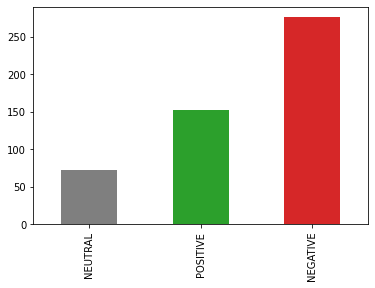

In [ ]:
totals = labeled_df.label.value_counts()
length = len(labeled_df)

totals.sort_values().plot(kind='bar', color=['C7', 'C2', 'C3'])
#sns.countplot(x='label', data=labeled_df)

total_negative = totals[0]
total_positive = totals[1]
total_neutral = totals[2]

print("Total: %s"%length)
print("Negative: %s"%percentage(total_negative, length))
print("Positive: %s"%percentage(total_positive, length))
print("Neutral: %s"%percentage(total_neutral, length))

## Cleaning

In [ ]:
#FILTERING
def filtering(text):
  filtered_text = re.sub(r'(?:\#|@|https?\://)\S+', '', text)
  return filtered_text.lower()

#TOKENIZER
def tokenizer(text):
  return word_tokenize(text)

#NLTK STOPWORDS AND PUNCTUATION
def remove_stopwords(tokens):
  stopwords_list = set(stopwords.words('portuguese') + list(punctuation))
  words = [word for word in tokens if word not in stopwords_list]
  return [t for t in words if re.match(r'[A-Za-z]', t)]

#NLTK STEMMING FOR PORTUGUESE (RSLPStemmer)
def stemming(tokens):
  return [RSLPStemmer().stem(t) for t in tokens]

def cleaning(text):
  clean_text = ''
  clean_text = filtering(text)
  clean_text = tokenizer(clean_text)
  return " ".join(remove_stopwords(clean_text))
  #clean_text = remove_stopwords(clean_text)
  #return " ".join(stemming(clean_text))
  

def drop_duplicates_and_na(df):
  return df.apply(tuple, 1).drop_duplicates().apply(list).to_frame()
  #return new_df[new_df[column].map(lambda d: len(d)) > 0]


## Data split (Train and Test)

['Aí gente eu tô com muito medo minha irmã vai ganhar baby em pleno surto do covid-19'
 'Conferência Episcopal recomenda comunhão na mão e omissão do gesto da paz nas missas: A Conferência Episcopal Portuguesa (CEP) recomendou hoje que, face ao surto de Covid-19, os fiéis recebam a comunhão na mão e que se omita, enquanto continuar a… '
 'Brasil ultrapassa 74 mil óbitos em decorrência do Covid-19 '
 'META DA QUARENTENA: chegar até o final dela sem mandar ninguém tomar no cu. #quarentena #COVID19 #FiqueEmCasa'
 'Senado aprova indenização a profissionais da saúde incapacitados pela covid-19 https://www.saomateusnews.com.br/politica/senado-aprova-indenizacao-a-profissionais-da-saude-incapacitados-pela-covid-19/']
<class 'numpy.ndarray'>
Train Dataset size:  350


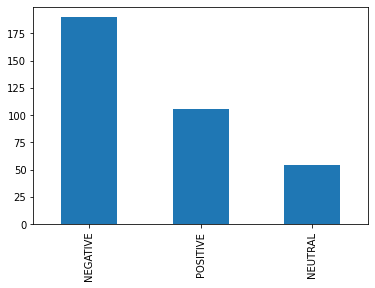

In [ ]:
text_train, text_test, label_train, label_test = train_test_split(labeled_df['text'].values, labeled_df['label'].values, test_size=0.3)

print(text_train[:5])
print(type(text_train))
print('Train Dataset size: ', len(text_train))
pd.value_counts(label_train).plot.bar()

['Eu já pressionei os parlamentares a votarem a favor da Lei COVID-19. Clique aqui para pressionar também e compartilhe nas suas redes. #maisdoquepalmas'
 'Admiro muito o jeito do r7 apresentar o jornal mas tive uma informação da UOL e da Band que sobe para 30 casos confirmados no Brasil de Covid19, qual a real quantidade de infectados. Aguardo retorno...'
 'Quero testar um negócio daqui uns dias. Você conhece pessoalmente alguém que esteja ou foi infectado por covid19?'
 'De acordo com a JN são 8000 mortos de COVID-19 no Brasil, o pico da epidemia não chegou e o inverno no Rio Grande está por vir... Ainda bem que é só uma gripezinha. ?????????? #vaipassar'
 'COVID-19: usuários do Twitter protestam por terem auxílio emergencial negado ']
<class 'numpy.ndarray'>
Test Dataset size:  150


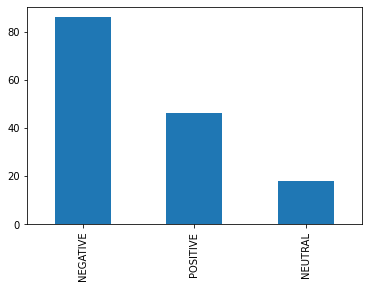

In [ ]:
print(text_test[:5])
print(type(text_test))
print('Test Dataset size: ', len(text_test))

pd.value_counts(label_test).plot.bar()

## Pipeline

### Model 1

In [ ]:
[cleaning(t) for t in text_train][:10]

['aí gente tô medo irmã vai ganhar baby pleno surto covid-19',
 'conferência episcopal recomenda comunhão mão omissão gesto paz missas conferência episcopal portuguesa cep recomendou hoje face surto covid-19 fiéis recebam comunhão mão omita enquanto continuar a…',
 'brasil ultrapassa mil decorrência covid-19',
 'meta quarentena chegar final mandar ninguém tomar cu',
 'senado aprova indenização profissionais saúde incapacitados covid-19',
 'pessoas morreram horas covid19 bem-vindos normalidade brasil tão bem cuidado governo bolsonaro',
 'butantan oferece testagem gratuita covid-19 capital paulista canal gama',
 'todo mundo torce pra ache rápido medicamento vacina covid-19 atenção milagres existem caminho ainda longo',
 'dica valiosa enfermeiras guerra contra covid-19',
 'estado bahia confirmou mortes hoje quarta-feira mortes estado brasil covid-19']

In [ ]:
#CountVectorizer(analyzer=cleaning, tokenizer=word_tokenize, ngram_range = (1, 2))
#('tfidf', TfidfTransformer()),

pipeline = Pipeline([
    ('Bag Of Words', CountVectorizer(analyzer=cleaning)),
    ('MultinomialNB', MultinomialNB()),
])

pipeline.fit(text_train, label_train)

Pipeline(memory=None,
         steps=[('Bag Of Words',
                 CountVectorizer(analyzer=<function cleaning at 0x7f24381042f0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('MultinomialNB',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
result = cross_val_predict(pipeline, text_test, label_test, cv=10)

In [ ]:
print("Accuracy: ", accuracy_score(label_test, result))
print()
print(classification_report(label_test, result))
print()
print(pd.crosstab(label_test, result, rownames=['x'], colnames=['y'], margins=True))

Accuracy:  0.5866666666666667

              precision    recall  f1-score   support

    NEGATIVE       0.65      0.76      0.70        86
     NEUTRAL       0.14      0.06      0.08        18
    POSITIVE       0.51      0.48      0.49        46

    accuracy                           0.59       150
   macro avg       0.43      0.43      0.42       150
weighted avg       0.55      0.59      0.56       150


y         NEGATIVE  NEUTRAL  POSITIVE  All
x                                         
NEGATIVE        65        5        16   86
NEUTRAL         12        1         5   18
POSITIVE        23        1        22   46
All            100        7        43  150


### Model 2

In [ ]:
vectorizer = CountVectorizer(analyzer=cleaning)
train_freq = vectorizer.fit_transform(text_train)
print(type(train_freq))
print(train_freq.shape)

test_freq = vectorizer.transform(text_test)

model = MultinomialNB()
model.fit(train_freq, label_train)

predicted = model.predict(test_freq)
print("Accuracy:", accuracy_score(label_test, predicted))

results = []
for t, c in zip(text_test, model.predict(test_freq)):
  results.append([t, c])

pd.set_option('max_colwidth', 150)
df = pd.DataFrame(results, columns = ['text', 'label'])
df[:5]



<class 'scipy.sparse.csr.csr_matrix'>
(350, 51)
Accuracy: 0.5933333333333334


,text,label
0,Eu já pressionei os parlamentares a votarem a favor da Lei COVID-19. Clique aqui para pressionar também e compartilhe nas suas redes. #maisdoquepa...,NEGATIVE
1,"Admiro muito o jeito do r7 apresentar o jornal mas tive uma informação da UOL e da Band que sobe para 30 casos confirmados no Brasil de Covid19, q...",POSITIVE
2,Quero testar um negócio daqui uns dias. Você conhece pessoalmente alguém que esteja ou foi infectado por covid19?,NEGATIVE
3,"De acordo com a JN são 8000 mortos de COVID-19 no Brasil, o pico da epidemia não chegou e o inverno no Rio Grande está por vir... Ainda bem que é ...",NEGATIVE
4,COVID-19: usuários do Twitter protestam por terem auxílio emergencial negado,NEUTRAL


## Filters

### Hashtags frequency

FreqDist({'#COVID19': 4624, '#covid19': 2317, '#coronavirus': 2190, '#Covid19': 1799, '#Covid_19': 1662, '#FiqueEmCasa': 1056, '#coronavirusbrasil': 803, '#coronav': 772, '#coronavirusnobrasil': 635, '#Coronav': 604, ...})
None



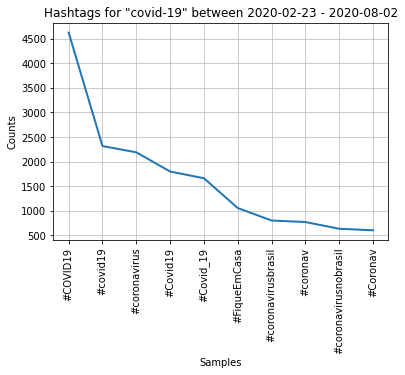

In [ ]:
def twitter_hastag():
  hashtags = filter(lambda x: x != "", df['hashtags'])
  hashtags = ' '.join(list(hashtags)).split(' ')

  hashtag_frequency = FreqDist(hashtags)

  print(hashtag_frequency.pprint(10))
  print()
  hashtag_frequency.plot(10, title="Hashtags for \"%s\" between %s - %s"%(twitter__query, period[0], period[1]))

twitter_hastag()

### Mentions

FreqDist({'@jairbolsonaro': 621, '@YouTube': 425, '@UOL': 399, '@UOLNoticias': 338, '@minsaude': 328, '@jornalnacional': 182, '@change_br': 136, '@RodrigoMaia': 98, '@portalR7': 94, '@lhmandetta': 93, ...})
None



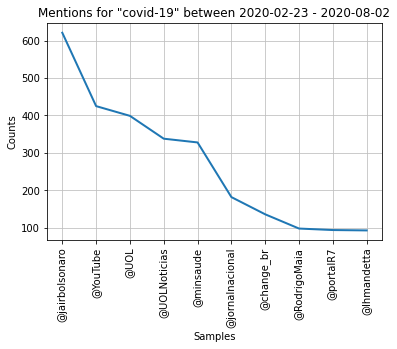

In [ ]:
def twitter_mentions():
  mentions = filter(lambda x: x != "", df['mentions'])
  mentions = ' '.join(list(mentions)).split(' ')

  mentions_frequency = FreqDist(mentions)

  print(mentions_frequency.pprint(10))
  print()
  mentions_frequency.plot(10, title="Mentions for \"%s\" between %s - %s"%(twitter__query, period[0], period[1]))

twitter_mentions()

### Word Count

FreqDist({'covid-19': 718, 'covid19': 224, 'https': 196, 'casos': 182, 'brasil': 169, 'mortes': 131, 'saúde': 71, 'mil': 68, 'covid': 65, 'sobre': 62, 'coronavírus': 61, 'pandemia': 59, 'coronavirus': 58, 'estado': 57, 'contra': 57, 'via': 57, 'http': 52, 'bolsonaro': 51, 'confirmados': 51, 'dia': 49, 'hoje': 47, 'pra': 46, 'mundo': 45, 'mortos': 44, 'pessoas': 43, ...})
None



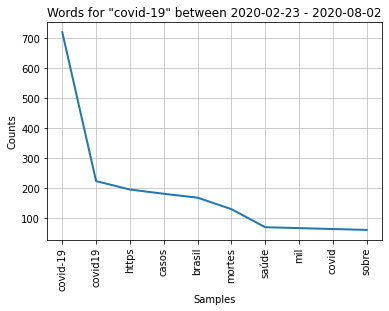

In [ ]:
def twitter_wordcount():
  text_list = filter(lambda x: x != "", sample['text'])
  text_list = ' '.join(list(text_list)).split(' ')

  clean_text = []
  for text in text_list:
    clean_text += remove_stopwords(text)

  word_frequency = FreqDist(clean_text)

  print(word_frequency.pprint(25))
  print()
  word_frequency.plot(10, title="Words for \"%s\" between %s - %s"%(twitter__query, period[0], period[1]))

twitter_wordcount()

# News Module

## G1/Globo

### Config

In [ ]:
news__query = query
min_results_day = 20

#source urls
source_search_base_url = 'https://g1.globo.com/busca/?'
web_archive_search_base_url = 'https://web.archive.org/web/'

#selectors
result_href_selector = 'div[class*="widget--info__text-container"] > a[href^="//g1.globo.com/busca/"]'

title_selector = 'h1[class*="content-head__title"]'
subtitle_selector = 'div[class*="medium-centered subtitle"]'
content_selector = 'p[class*="content-text__container"]'
date_selector = 'p[class*="content-publication-data__updated"] > time'
from_selector = 'p[class*="content-publication-data__from"]'
author_selector = 'p[class*="top__signature__text__author-name"]'
blockquote_content_selector = 'blockquote[class*="content-blockquote"]'
media_description_selector = 'p[class*="content-media__description"]'

#regex rules
regex_rule_1 = '(http[s]?:\/\/g1.globo.com)+[^\s(["<,>]*\.[^\s[",><]*'
regex_rule_2 = '\/video|ao-vivo\/'

date_regex = '\d{4}(\/)(((0)[0-9])|((1)[0-2]))(\/)([0-2][0-9]|(3)[0-1])'

news__filename = 'news_g1_dataset-%s-from_%s_to_%s'%(news__query, period[0], period[1])
news__columns = ['id', 'date', 'time', 'title', 'subtitle', 'url', 'text']

### Scraping

In [ ]:
def parse_urls_from(content):
  soup = BeautifulSoup(content)
  hrefs = soup.select(result_href_selector)
  
  urls = []

  for hr in hrefs:
      href = hr['href']
      encoded_href = href.split('&')[3][2:]
      decoded_href = urllib.parse.unquote(encoded_href)

      rule_1 = re.search(regex_rule_1, decoded_href)
      rule_2 = re.search(regex_rule_2, decoded_href)

      if rule_1 and not rule_2:
          urls.append(decoded_href)
  
  return urls

def results_by_page():
  species = "not%C3%ADcias"
  results = []
  # date_range_weeks = pd.date_range(start = period[0], end = period[1], freq='W')

  # i = 0
  # while True:
    # if (i + 1 >= len(date_range_weeks)): break

    # date_range = pd.date_range(start = date_range_weeks[i], end = date_range_weeks[i + 1])
  date_range = pd.date_range(start = period[0], end = period[1])
    # i += 1

  j = 0
  while True:
    if (j + 1 > len(date_range)): break

    date_start = str(date_range[j].date())
    #date_end = str(date_range[j+1].date())
    date_end = str(date_range[j].date())
    
    j += 1

    #for page_n in range(1, 5):
    for page_n in range(1, 2):
      params = 'https://g1.globo.com/busca/?q=%s&page=%s&order=relevant&from=%s&to=%s&species=%s'%(
          news__query,
          page_n,
          date_start+"T00%3A00%3A00-0300",
          date_end+"T23%3A59%3A59-0300",
          species
      )
      #print("[INFO][...] {} | page {}".format(date_start, page_n))
      #print("[INFO][...] {}".format(params))
      
      try:
        response = urllib.request.urlopen(params)
        content = response.read().decode('utf-8', 'ignore')
        page_results = parse_urls_from(content)
        results += page_results
        #print("[INFO][...] {} results".format(len(page_results)))
        
      except Exception as e:
        print(e)

  return results

def bulk_results():
  results = []
  
  new_results = results_by_page()
  #if (len(new_results) == 0 or len(results) >= min_results_day): break
  results += new_results

  print("[INFO][...] {} news found".format(len(results)))
  return results

### Wayback Machine

In [ ]:
def get_content_from(url):
  content = ''
  try:
    request_url = 'https://web.archive.org/web/%s'%(url)
    #print('[Original] %s'%url)
    #print('[Archive] %s'%request_url)
    response = urllib.request.urlopen(request_url)
    content = response.read().decode('utf-8', 'ignore')
  except Exception as e:
    print("[ERROR][{}] {}".format(log_time(), e))
    print(e)
  
  return content

### Parse Content

In [ ]:
def parse_content_from(news):
  soup = BeautifulSoup(news)

  title = soup.select(title_selector)[0].get_text()+'.' if soup.select(title_selector) else ''
  subtitle = soup.select(subtitle_selector)[0].get_text()+'.' if soup.select(subtitle_selector) else ''
  date = soup.select(date_selector)[0].get_text() if soup.select(date_selector) else ''
  #author = soup.select(author_selector)[0].get_text() if soup.select(author_selector) else ''
  #media_author = soup.select(from_selector)[0].get_text() if soup.select(from_selector) else ''
  contents = soup.select(content_selector)
  blockquote_contents = soup.select(blockquote_content_selector)
  #media_descriptions = soup.select(media_description_selector)

  text = ''
  text += title.strip()
  text += subtitle.strip()
  
  if date:
    date = datetime.strptime(date.strip(), '%d/%m/%Y %Hh%M')

  for c in contents:
    text += c.get_text()

  for bqc in blockquote_contents:
    text += bqc.get_text()+'.'

  #for md in media_descriptions:
  #    text += md.get_text()+'.'

  return title, subtitle, date, text
          
  #return text

### Fetch and save

In [ ]:
start_time = print_exec_start()

urls = []
urls = bulk_results()
save_txt_to_drive(urls, 'g1_news_url_list')
print("[INFO][{}] saving {} urls".format(log_time(), len(urls)))

print_exec_time(start_time)

--- Started at 2020/08/12 10:45
[INFO][...] 2429 news found
[INFO][2020/08/12 10:51] saving 2429 urls
--- 378.5480763912201 seconds ---
--- 6.0 minutes ---
--- 0.0 hours ---


In [ ]:
start_time = print_exec_start()

news = ''
news_list = []
count = 0

for index, url in enumerate(urls, start=1):
  news = get_content_from(url)
  title, subtitle, date, text = parse_content_from(news)
  #date = re.search(date_regex, url).group(0)
  id = generate_hash_md5(url)

  d = {
    'id': id,
    'date': date.date(),
    'time': date.time(),
    'title': title,
    'subtitle': subtitle,
    'url': url,
    'text': text,
  }
  news_list.append(d)
  print("[INFO][...] {} {} {}".format(id, date, title))

  if ((index % 100) == 0):
    print("[INFO][..ZzZz..] Saving and going to take a nap")
    news_df = pd.DataFrame(news_list, columns=news__columns)
    save_csv_to_drive(news_df, news__filename+'_'+str(index))
    count += len(news_list)
    news_list = []

    time.sleep(60*5)

if news_list:
  print("[INFO][...] Saving")
  count += len(news_list)

  news_df = pd.DataFrame(news_list, columns=news__columns)
  save_csv_to_drive(news_df, news__filename+'_'+str(count))
  print("[INFO][{}] {} news collected".format(log_time(), count))

print_exec_time(start_time)

### Cleaning

In [ ]:
def remove_stopwords(text, tokenize=True):
  sentences = []
  
  words = word_tokenize(text.lower())

  stopwords_list = set(stopwords.words('portuguese') + list(punctuation))
  text_without_stopwords = [word for word in words if word not in stopwords_list]
  clean_text = [t for t in text_without_stopwords if re.match(r'[A-Za-z]', t)]
  
  if tokenize:
    sentences = sent_tokenize(text)
    return clean_text, sentences
  else:
    return clean_text

In [ ]:
def word_count_frequency(clean_text, sentences):
  frequency = FreqDist(clean_text)
  main_sentences = defaultdict(int)

  for i, sentence in enumerate(sentences):
      for word in word_tokenize(sentence.lower()):
          if word in frequency:
              main_sentences[i] += frequency[word]

  return frequency, main_sentences

### Filters

#### Word Count

In [ ]:
def word_count_report(text):
  clean_text_bag = []
  sentences_bag = []
  
  clean_text, sentences = remove_stopwords(text)
  clean_text_bag += clean_text
  sentences_bag += sentences

  frequency, main_sentences = word_count_frequency(clean_text_bag, sentences_bag)
  idx_main_sentences = nlargest(4, main_sentences, main_sentences.get)

  print(frequency.pprint(25))
  print()
  frequency.plot(25, title="Word count")

  print("The 4 most relevant sentences for \"%s\""%(query))
  for i in sorted(idx_main_sentences):
      print("[%s] %s"%(i, sentences_bag[i]))
